In [1]:
import datetime,time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import numpy as np
import skmob
import gc
import sys
import math
from skmob.preprocessing import filtering
from skmob.preprocessing import detection
from geopy.distance import geodesic

In [ ]:
'''
%%bigquery raw_df
SELECT TIMESTAMP(FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', location_at), 'Europe/London') location_at,
                                                                        hashed_advertiser_id as user_id, latitude , longitude , horizontal_accuracy,  
                                                                        ST_GEOGPOINT(longitude, latitude) as point
FROM            `thesisprojects2019.raw_data.gps_mayjune21`
WHERE           location_at BETWEEN '2021-05-15 08:00:00' AND '2021-05-15 08:10:00'
AND             horizontal_accuracy <= 500


'''
                                                        
                                          
        

In [ ]:
'''
%%bigquery raw_df
SELECT          location_at, hashed_advertiser_id, latitude, longitude, ST_GEOGPOINT(longitude, latitude) as point
FROM            `thesisprojects2019.raw_data.gps_mayjune21` 
WHERE           hashed_advertiser_id 
                 IN            (SELECT DISTINCT hashed_advertiser_id 
                               FROM  (
                                            SELECT      hashed_advertiser_id, point
                                            FROM        (
                                                        SELECT          TIMESTAMP(FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', location_at), 'Europe/London') location_at,
                                                                        hashed_advertiser_id, latitude, longitude,  
                                                                        ST_GEOGPOINT(longitude, latitude) as point
                                                        FROM            `thesisprojects2019.raw_data.gps_mayjune21` 
                                                        WHERE           location_at BETWEEN '2021-05-17 00:00:00 UTC' AND '2021-05-24 00:00:00 UTC'
                                                        AND             horizontal_accuracy <= 500
                                            ) as p 
                                            WHERE       ST_CONTAINS(ST_GEOGFROMTEXT('POLYGON((-0.1442620096720626 51.52409589840259,-0.1460644541300704 51.52532414177173,-0.14735191445721885 51.52511053660915,-0.15267341714276572 51.53744459279257,-0.16383140664471885 51.534935336997016,-0.17083234559290394 51.538649352164626,-0.17890043030970082 51.5396102816751,-0.19229001771204457 51.53630032794567,-0.21546430360071644 51.55647662860774,-0.2027613617061852 51.55807753910604,-0.1952082611202477 51.56095903600118,-0.19366330872766957 51.56245307362608,-0.1842219329952477 51.56725500496954,-0.1718623138546227 51.57194973639285,-0.16396589051477894 51.572696580783074,-0.15091962586634144 51.57120287973223,-0.14250821839563832 51.56928233483202,-0.1409632660030602 51.56533429328683,-0.1409632660030602 51.560318719135616,-0.13804502259485707 51.55647662860774,-0.13330870998368827 51.55295576016384,-0.13056212795243827 51.55007375619157,-0.12712890041337577 51.547938820717775,-0.12541228664384452 51.54260104371472,-0.12489730251298514 51.53918453780938,-0.12249404323564139 51.53790328196765,-0.12232238185868827 51.530642150864956,-0.1200226391171677 51.53098215044702,-0.11804853328220677 51.53060838720603,-0.11581693538181614 51.52975405970354,-0.11581693538181614 51.52841914088527,-0.11444364436619114 51.526870586019605,-0.10946546443455052 51.524200540148584,-0.10680471309177708 51.52206439072073,-0.10543142207615208 51.5185929341764,-0.10800634273044896 51.51768497111879,-0.11401449092380833 51.51800543073537,-0.11221204646580052 51.51570875365943,-0.11856351741306614 51.51464049230514,-0.12671743281833958 51.512610726709944,-0.12912069209568333 51.512557310604485,-0.1305798137997849 51.516403110104974,-0.13092313655369114 51.517311098716355,-0.13358388789646458 51.517311098716355,-0.13710294612400364 51.519020204646246,-0.14285360225193333 51.52377331827951,-0.1442620096720626 51.52409589840259))'), p.point)
                 )
                 )
AND             location_at BETWEEN  '2021-05-17 00:00:00 UTC' AND '2021-05-24 00:00:00 UTC'
'''

        

In [ ]:
%%bigquery raw_df
SELECT DISTINCT location_at as datetime,hashed_advertiser_id as user_id,latitude as lat,longitude as lon FROM `thesisprojects2019.Szymon.MAY_17_24`

In [ ]:
raw_df.user_id.nunique()

In [ ]:
#convert lat and lon to float
raw_df[['lat','lon']] = raw_df[['lat','lon']].astype(float)

In [ ]:
# averaging point with the same timestamp and different location
av_df=raw_df.groupby(['user_id','datetime']).mean().reset_index()

In [ ]:
# calculating number of gps points per user
More_10=av_df.groupby(['user_id']).count().reset_index()

#removing users with less the 10 gps points
More_10=More_10[More_10.lat>10].reset_index().iloc[:,1:3]
More_10=More_10.rename(columns={'datetime': 'us_no_points'})
df = pd.merge(More_10, av_df, how="left", on=["user_id", "user_id"])

# calculating dwell time and divinging trajectories into trips

In [ ]:
%%time
#dwell_time=df.groupby(['user_id']).apply(lambda x: x.datetime.diff(periods=1)).reset_index()
dwell_time=df.groupby(['user_id']).datetime.diff(periods=1).dt.total_seconds()

In [ ]:
dwell_time=dwell_time.to_frame()
dwell_time=dwell_time.rename(columns={"datetime": "dwell_time"})
df_dw=pd.merge(df,dwell_time, left_index=True, right_index=True)

In [ ]:
df_users=df_dw.groupby(df_dw.user_id)
users_dict= df_users.indices
users_labels= list(users_dict)

In [ ]:
%%time 
#44min

df_dw['tripID']=0
id=0
for userID in users_labels:
    user_df= df_dw.iloc[users_dict[userID]]
    id+=1
    for i in users_dict[userID]:       
        if np.isnan(user_df.dwell_time.loc[i]):
            df_dw.at[i,'tripID']=id
            continue     
        if 28800>user_df.dwell_time.loc[i] >900 : # dwell time longer than 15min
            origin = (user_df.lat.loc[i],user_df.lon.loc[i])  # (latitude, longitude) 
            dist = (user_df.lat.loc[i-1], user_df.lon.loc[i-1])
            d=geodesic(origin, dist).meters
            df_dw.at[i,'tripID']=id
            if d<150:#position change less than 150m
                id+=1
                df_dw.at[i,'tripID']=id
        elif user_df.dwell_time.loc[i]>23520: # dwell time longer than 6h 32min then...
            id+=1
            df_dw.at[i,'tripID']=id
        else:
            df_dw.at[i,'tripID']=id

In [ ]:
#removing trips with less than 10 gps points
More_10=df_dw.groupby(['tripID']).count().reset_index()
More_10=More_10[More_10.user_id>10].reset_index().iloc[:,1:3]
More_10=More_10.rename(columns={'user_id': 'tr_no_points'})
#df with trips
df_tr = pd.merge(More_10, df_dw, how="left", on=["tripID", "tripID"])
df_tr=df_tr[['datetime','lat','lon','tripID','tr_no_points']]

In [ ]:
#saving df_tr to pickle
df_tr.to_pickle('Data/trips_final.pkl')

In [2]:
#loading df_tr 
df_tr = pd.read_pickle('Data/trips_final.pkl')

In [3]:
# calculation average epoch rate of the trip

In [4]:
epoch_rate=df_tr.groupby(['tripID']).apply(lambda x: ((x.datetime.max()-x.datetime.min())/len(x.datetime)).seconds).reset_index()
epoch_rate=epoch_rate.rename(columns={0: "epoch_rate"})

In [45]:
#epoch_rate.to_pickle('Data/all_epoch_rates.pkl')

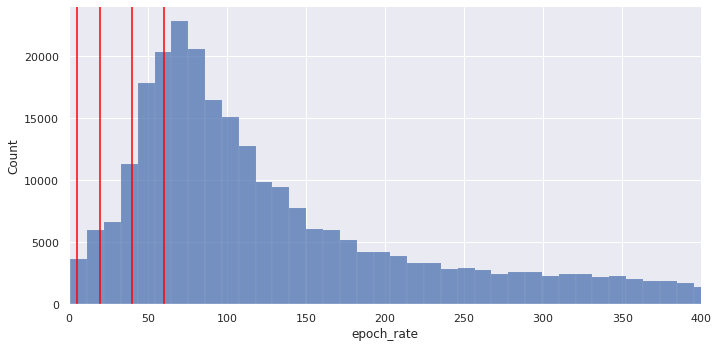

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

ax=sns.displot(epoch_rate, x="epoch_rate",bins=1000,height=5, aspect=2/1).set(xlim=(0,400))#kind="kde",bw_adjust=.25
e= [5,20,40,60]
[plt.axvline(x,color='red') for x in e]


In [39]:
epoch_rate['epoch_rate'].mean()

206.64246527862872

In [7]:
#remove trips with average epoch rate higher than [5s,20s,40s or 60s]
epoch_rate=epoch_rate[epoch_rate.epoch_rate<40.1]
df_ep=pd.merge(epoch_rate,df_tr, how="left", on=["tripID", "tripID"])

In [8]:
#saving df_ep to pickle
df_ep.to_pickle('Data/trips_ep_40_final.pkl')

In [9]:
#loading df_ep
df_ep = pd.read_pickle('Data/trips_ep_40_final.pkl')

In [10]:
df_ep

,tripID,epoch_rate,datetime,lat,lon,tr_no_points
0,756,35,2021-05-18 16:43:22+00:00,51.378008,-0.109672,254
1,756,35,2021-05-18 16:44:52+00:00,51.378010,-0.109647,254
2,756,35,2021-05-18 16:48:11+00:00,51.379142,-0.113149,254
3,756,35,2021-05-18 16:48:56+00:00,51.379450,-0.111513,254
4,756,35,2021-05-18 16:49:41+00:00,51.378200,-0.110037,254
...,...,...,...,...,...,...
3692754,4673928,4,2021-05-22 16:00:49+00:00,51.519818,-0.131769,13
3692755,4673928,4,2021-05-22 16:00:54+00:00,51.519811,-0.131744,13
3692756,4673928,4,2021-05-22 16:00:59+00:00,51.519812,-0.131745,13
3692757,4673928,4,2021-05-22 16:01:04+00:00,51.519813,-0.131745,13


# Divinding trips into one mode stages

In [11]:
#identifying possible walk stages

In [12]:
#calculating delta time

In [13]:
%%time
delta_time=df_ep.groupby(['tripID']).datetime.diff(periods=1).dt.total_seconds()

CPU times: user 10.1 s, sys: 429 ms, total: 10.5 s
Wall time: 10.5 s


In [14]:
delta_time=delta_time.to_frame()
delta_time=delta_time.rename(columns={"datetime": "delta_time"})
df_dl=pd.merge(df_ep,delta_time, left_index=True, right_index=True)

In [15]:
df_dl.delta_time=df_dl.delta_time.shift(periods=-1)
df_dl.delta_time=df_dl.delta_time.fillna(method='ffill')

In [16]:
#calculating relative distance

In [17]:
df_dl['dest_lat']=df_dl.lat.shift(periods=-1)
df_dl['dest_lon']=df_dl.lon.shift(periods=-1)

In [18]:
df_dl[['dest_lat','dest_lon']]=df_dl[['dest_lat','dest_lon']].fillna(method='ffill')

In [19]:
%%time
distance=df_dl.apply(lambda x: geodesic((x.lat,x.lon), (x.dest_lat,x.dest_lon)).meters,axis = 1)#28min

CPU times: user 12min 9s, sys: 1.96 s, total: 12min 11s
Wall time: 12min 11s


In [20]:
distance=distance.to_frame()
distance=distance.rename(columns={0: "distance"})
df_dis=pd.merge(df_dl,distance, left_index=True, right_index=True)

In [21]:
#saving and loading results
df_dis.to_pickle('Data/dis_delta_40_final.pkl')
df_dis = pd.read_pickle('Data/dis_delta_40_final.pkl')

In [22]:
#step1
#calculating velocity/speed
df_dis['speed']=df_dis['distance']/df_dis['delta_time']

In [23]:
#changing last speed in every group to nan and then to the values from a row above
df_trip=df_dis.groupby(df_dis.tripID)
trips_dict= df_trip.indices
trips_labels= list(trips_dict)

index=[]
for tripID in trips_labels:
    index.append(trips_dict[tripID][-1])

In [24]:
df_dis.loc[index,'speed']=np.nan
df_dis.speed=df_dis.speed.fillna(method='ffill')

In [25]:
df_dis.loc[index,'distance']=np.nan
df_dis.distance=df_dis.distance.fillna(method='ffill')

In [26]:
#calculating acceleration

In [27]:
df_dis['speed_2']=df_dis.speed.shift(periods=-1)

In [28]:
df_dis.loc[index,'speed_2']=np.nan
df_dis.speed_2=df_dis.speed_2.fillna(method='ffill')

In [29]:
df_dis['acc']=np.abs(df_dis['speed_2']-df_dis['speed'])/df_dis['delta_time']

In [30]:
#marking possible walk points with 1 
df_dis['walk_stage_poss']=0
df_dis.loc[(df_dis.speed<1.8)&(df_dis.acc<0.6),'walk_stage_poss']=1

In [31]:
df_dis.tripID.nunique()

23570

In [32]:
#step 2
# reversing assinged walk or non-walk value if the stage lasted less the 61s
df_dis["walk_stage_poss_shift"] = df_dis["walk_stage_poss"].shift()
df_dis["cumsum"] = (df_dis["walk_stage_poss"] != df_dis["walk_stage_poss_shift"])
df_dis["tripID_shift"] = df_dis["tripID"].shift()
df_dis["cumsum_trip"] = (df_dis["tripID"] != df_dis["tripID_shift"])
df_dis["stageID"] = (df_dis["cumsum_trip"].astype(int) + df_dis["cumsum"].astype(int)).cumsum()

In [33]:
df_dis.stageID.nunique()

348315

In [34]:
df_dis.loc[400:415]#[df_dis.stageID==21]

,tripID,epoch_rate,datetime,lat,lon,tr_no_points,delta_time,dest_lat,dest_lon,distance,speed,speed_2,acc,walk_stage_poss,walk_stage_poss_shift,cumsum,tripID_shift,cumsum_trip,stageID
400,786,23,2021-05-19 17:13:59+00:00,51.517105,-0.123174,465,2.0,51.517029,-0.123354,15.086853,7.543427,7.581524,0.019049,0,0.0,False,786.0,False,51
401,786,23,2021-05-19 17:14:01+00:00,51.517029,-0.123354,465,3.0,51.516855,-0.123526,22.744573,7.581524,25.698083,6.038853,0,0.0,False,786.0,False,51
402,786,23,2021-05-19 17:14:04+00:00,51.516855,-0.123526,465,3.0,51.517137,-0.122511,77.094249,25.698083,35.127083,3.143000,0,0.0,False,786.0,False,51
403,786,23,2021-05-19 17:14:07+00:00,51.517137,-0.122511,465,3.0,51.516673,-0.123835,105.381248,35.127083,1.613004,11.171359,0,0.0,False,786.0,False,51
404,786,23,2021-05-19 17:14:10+00:00,51.516673,-0.123835,465,2.0,51.516662,-0.123878,3.226008,1.613004,3.203864,0.795430,0,0.0,False,786.0,False,51
405,786,23,2021-05-19 17:14:12+00:00,51.516662,-0.123878,465,3.0,51.516620,-0.123999,9.611593,3.203864,5.159679,0.651938,0,0.0,False,786.0,False,51
406,786,23,2021-05-19 17:14:15+00:00,51.516620,-0.123999,465,2.0,51.516567,-0.124121,10.319359,5.159679,5.823459,0.331890,0,0.0,False,786.0,False,51
407,786,23,2021-05-19 17:14:17+00:00,51.516567,-0.124121,465,2.0,51.516504,-0.124255,11.646917,5.823459,3.625562,1.098949,0,0.0,False,786.0,False,51
408,786,23,2021-05-19 17:14:19+00:00,51.516504,-0.124255,465,2.0,51.516458,-0.124329,7.251123,3.625562,0.724957,1.450302,0,0.0,False,786.0,False,51
409,786,23,2021-05-19 17:14:21+00:00,51.516458,-0.124329,465,3.0,51.516442,-0.124311,2.174871,0.724957,1.107937,0.127660,1,0.0,True,786.0,False,52


In [35]:
walk_no_walk=df_dis.groupby(['stageID']).delta_time.sum().reset_index()
walk_no_walk=walk_no_walk[walk_no_walk.delta_time<61].iloc[:,0]
walk_no_walk=walk_no_walk.to_list()

In [36]:
non_walk_to_walk=((df_dis['stageID'].isin(walk_no_walk))& (df_dis.walk_stage_poss==0))
walk_to_non_walk=((df_dis['stageID'].isin(walk_no_walk))& (df_dis.walk_stage_poss==1))

In [37]:
df_dis.loc[non_walk_to_walk,'walk_stage_poss']=1
df_dis.loc[walk_to_non_walk,'walk_stage_poss']=0

In [38]:
#step 3
#assigning certainty to the stage based on its length threshold 50m
df_dis["walk_stage_poss_shift"] = df_dis["walk_stage_poss"].shift()
df_dis["cumsum"] = (df_dis["walk_stage_poss"] != df_dis["walk_stage_poss_shift"])
df_dis["tripID_shift"] = df_dis["tripID"].shift()
df_dis["cumsum_trip"] = (df_dis["tripID"] != df_dis["tripID_shift"])
df_dis["stageID_step3"] = (df_dis["cumsum_trip"].astype(int) + df_dis["cumsum"].astype(int)).cumsum()

In [39]:
uncertain=df_dis.groupby(['stageID_step3']).distance.sum().reset_index()
uncertain=uncertain[uncertain.distance<50].iloc[:,0].to_list()

In [40]:
df_dis['certain_stage']=1

In [41]:
df_dis.loc[(df_dis['stageID_step3'].isin(uncertain)),'certain_stage']=0

In [42]:
df_dis.stageID_step3.nunique()

222432

In [43]:
# changing stages to non_walk if there are more the 3 consecutive uncertain stages
uncertain_stage=df_dis.groupby(['stageID_step3','tripID']).certain_stage.mean().reset_index()
uncertain_stage["certain_stage_shift"] = uncertain_stage["certain_stage"].shift()
uncertain_stage["cumsum"] = (uncertain_stage["certain_stage"] != uncertain_stage["certain_stage_shift"])
uncertain_stage["tripID_shift"] = uncertain_stage["tripID"].shift()
uncertain_stage["cumsum_trip"] = (uncertain_stage["tripID"] != uncertain_stage["tripID_shift"])
uncertain_stage["certain_stage_ID"] = (uncertain_stage["cumsum_trip"].astype(int) + uncertain_stage["cumsum"].astype(int)).cumsum()

In [44]:
uncertain_stage

,stageID_step3,tripID,certain_stage,certain_stage_shift,cumsum,tripID_shift,cumsum_trip,certain_stage_ID
0,2,756,1,NaN,True,NaN,True,2
1,3,756,1,1.0,False,756.0,False,2
2,4,756,1,1.0,False,756.0,False,2
3,5,756,1,1.0,False,756.0,False,2
4,6,756,1,1.0,False,756.0,False,2
...,...,...,...,...,...,...,...,...
222427,229804,4673660,0,0.0,False,4673660.0,False,89897
222428,229805,4673660,0,0.0,False,4673660.0,False,89897
222429,229806,4673928,0,0.0,False,4673660.0,True,89898
222430,229807,4673928,0,0.0,False,4673928.0,False,89898


In [45]:
uncertain_3=uncertain_stage.groupby(['certain_stage_ID']).certain_stage.agg(['mean','count']).reset_index()

In [46]:
uncertain_3=uncertain_3[(uncertain_3['mean']==0)&(uncertain_3['count']>3)].iloc[:,0]

In [47]:
uncertain_3=((uncertain_stage['certain_stage_ID'].isin(uncertain_3)))

In [48]:
stage_to_transform=uncertain_stage.loc[uncertain_3,'stageID_step3']

In [49]:
df_dis.loc[(df_dis['stageID_step3'].isin(stage_to_transform)),'walk_stage_poss']=0

In [50]:
#step 4
df_dis["walk_stage_poss_shift"] = df_dis["walk_stage_poss"].shift()
df_dis["cumsum"] = (df_dis["walk_stage_poss"] != df_dis["walk_stage_poss_shift"])
df_dis["tripID_shift"] = df_dis["tripID"].shift()
df_dis["cumsum_trip"] = (df_dis["tripID"] != df_dis["tripID_shift"])
df_dis["stageID_final"] = (df_dis["cumsum_trip"].astype(int) + df_dis["cumsum"].astype(int)).cumsum()

In [51]:
df_dis.stageID_final.nunique()

166678

In [52]:
#removing stages with less the 10 points

In [53]:
no_pt_stage=df_dis.groupby('stageID_final').tripID.count().reset_index()

In [54]:
too_many_pt_stage=no_pt_stage[no_pt_stage.tripID>200].iloc[:,0].to_list()
no_pt_stage=no_pt_stage[no_pt_stage.tripID>10].iloc[:,0].to_list()

In [55]:
df_dis=df_dis.loc[(df_dis['stageID_final'].isin(no_pt_stage))]

In [56]:
df_dis.loc[(df_dis['stageID_final'].isin(too_many_pt_stage))]

,tripID,epoch_rate,datetime,lat,lon,tr_no_points,delta_time,dest_lat,dest_lon,distance,...,acc,walk_stage_poss,walk_stage_poss_shift,cumsum,tripID_shift,cumsum_trip,stageID,stageID_step3,certain_stage,stageID_final
3581,5294,37,2021-05-21 12:12:45+00:00,52.661815,-1.117014,397,17.0,52.661727,-1.115327,114.562900,...,0.062655,0,1.0,True,5294.0,False,382,214,1,180
3582,5294,37,2021-05-21 12:13:02+00:00,52.661727,-1.115327,397,45.0,52.662946,-1.112130,255.323975,...,0.136691,0,0.0,False,5294.0,False,382,214,1,180
3583,5294,37,2021-05-21 12:13:47+00:00,52.662946,-1.112130,397,46.0,52.667189,-1.108138,543.948266,...,0.257064,0,0.0,False,5294.0,False,382,214,1,180
3584,5294,37,2021-05-21 12:14:33+00:00,52.667189,-1.108138,397,46.0,52.667189,-1.108138,0.000000,...,0.212960,0,0.0,False,5294.0,False,383,214,1,180
3585,5294,37,2021-05-21 12:15:19+00:00,52.667189,-1.108138,397,46.0,52.670933,-1.105600,450.623467,...,0.248613,0,0.0,False,5294.0,False,384,214,1,180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692126,4671168,35,2021-05-21 17:25:04+00:00,51.306136,-0.153863,488,45.0,51.306970,-0.156862,228.791730,...,0.247042,0,0.0,False,4671168.0,False,355295,229765,1,174849
3692127,4671168,35,2021-05-21 17:25:49+00:00,51.306970,-0.156862,488,46.0,51.313041,-0.152345,745.252365,...,0.117874,0,0.0,False,4671168.0,False,355295,229765,1,174849
3692128,4671168,35,2021-05-21 17:26:35+00:00,51.313041,-0.152345,488,48.0,51.317374,-0.149650,517.389839,...,0.149571,0,0.0,False,4671168.0,False,355295,229765,1,174849
3692129,4671168,35,2021-05-21 17:27:23+00:00,51.317374,-0.149650,488,43.0,51.317095,-0.151825,154.780780,...,0.113207,0,0.0,False,4671168.0,False,355295,229765,1,174849


In [57]:
df_dis

,tripID,epoch_rate,datetime,lat,lon,tr_no_points,delta_time,dest_lat,dest_lon,distance,...,acc,walk_stage_poss,walk_stage_poss_shift,cumsum,tripID_shift,cumsum_trip,stageID,stageID_step3,certain_stage,stageID_final
12,756,35,2021-05-18 16:55:47+00:00,51.379045,-0.110588,254,45.0,51.380710,-0.113000,250.029344,...,0.007460,0,1.0,True,756.0,False,5,5,1,5
13,756,35,2021-05-18 16:56:32+00:00,51.380710,-0.113000,254,46.0,51.378565,-0.113385,240.143805,...,0.028158,0,0.0,False,756.0,False,5,5,1,5
14,756,35,2021-05-18 16:57:18+00:00,51.378565,-0.113385,254,45.0,51.379508,-0.111344,176.635759,...,0.112885,0,0.0,False,756.0,False,5,5,1,5
15,756,35,2021-05-18 16:58:03+00:00,51.379508,-0.111344,254,46.0,51.376619,-0.107591,414.233449,...,0.152593,0,0.0,False,756.0,False,5,5,1,5
16,756,35,2021-05-18 16:58:49+00:00,51.376619,-0.107591,254,45.0,51.370251,-0.105662,721.095257,...,0.142534,0,0.0,False,756.0,False,5,5,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3692741,4673660,3,2021-05-17 13:56:24+00:00,51.982631,-0.224228,21,4.0,51.982646,-0.224235,1.736915,...,0.038078,0,0.0,False,4673660.0,False,355364,229805,0,174885
3692742,4673660,3,2021-05-17 13:56:28+00:00,51.982646,-0.224235,21,4.0,51.982661,-0.224259,2.346163,...,0.016811,0,0.0,False,4673660.0,False,355364,229805,0,174885
3692743,4673660,3,2021-05-17 13:56:32+00:00,51.982661,-0.224259,21,2.0,51.982668,-0.224269,1.038590,...,0.190943,0,0.0,False,4673660.0,False,355364,229805,0,174885
3692744,4673660,3,2021-05-17 13:56:34+00:00,51.982668,-0.224269,21,2.0,51.982668,-0.224273,0.274818,...,0.000000,0,0.0,False,4673660.0,False,355364,229805,0,174885


In [58]:
#saving and loading results
df_dis.to_pickle('Data/stages_40_final.pkl')
df_dis = pd.read_pickle('Data/stages_40_final.pkl')

In [ ]:
data= skmob.TrajDataFrame(
df_dis[df_dis.stageID_final==480349],
latitude='lat',
longitude="lon",
user_id='stageID_final',
datetime='datetime')

In [ ]:
data.plot_trajectory(zoom=12, weight=3, opacity=0.9, tiles='Stamen Toner',max_users=100
                     ,start_end_markers=True,dashArray='5, 5')